# Exploratory Data Analysis
##### _Author: Calvin Chi_

---

First load the necessary packages and data.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.preprocessing import Imputer
import sys
import pickle
import copy
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import grid_search
from sklearn.metrics import confusion_matrix

File locations:

In [2]:
fileDir = "../data/payerChurnData_20160722.csv"
dataDir = "data/"
outputDir = "output/"

Read data:

In [348]:
data = pd.read_csv(fileDir)

Find out the data structure holding the data

In [4]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


Take a peek at the data...

In [5]:
data.head()

,idfa,rn,rev,hasemail,fb_friends,e_viptier,event_time,e_purchaseamount,credits,e_level,...,chb_28_21d,chb_21_14d,chb_14_7d,chb_7_6d,chb_6_5d,chb_5_4d,chb_4_3d,chb_3_2d,chb_2_1d,chb_1_0d
0,A1479ED8-C472-4D76-8C6D-625942E6ED74,61,14.99,True,0,4,2016-03-22 23:11:58,90000,2529.000000,332,...,65,70,83,7,7,8,7,2,7,6
1,30D7B4BC-0092-489B-BD69-591F68BB719A,46,4.99,True,0,3,2016-03-01 12:14:37,10000,30.000000,84,...,0,0,0,0,0,0,0,0,0,1
2,0226CE3B-60E8-4F0E-9AC8-9EEBE7C4CECF,37,49.99,True,0,4,2016-03-14 00:27:02,330000,99.884802,319,...,15,56,94,16,17,19,17,20,16,20
3,0F1FDC5B-A80D-4BF7-B1CE-7808BB922E77,10,14.99,False,0,3,2016-03-03 22:50:33,90000,3287.000000,150,...,43,51,48,7,6,8,5,6,6,4
4,53B61136-9C37-4EA9-8012-D4E8D105E257,21,4.99,True,0,0,2016-03-04 03:20:03,10000,66.000000,58,...,0,0,0,0,0,0,0,0,0,1


Assess the dimensions and print total list of features

In [328]:
print("Dimensions")
print(data.shape)
print("\n")
print(data.columns.values[:20])

Dimensions
(72962, 141)


['idfa' 'rn' 'rev' 'hasemail' 'fb_friends' 'e_viptier' 'event_time'
 'e_purchaseamount' 'credits' 'e_level' 'hours_until' 'hours_prior'
 'lapse7' 'lapse14' 'lapse30' 'ooc_56_49d' 'ooc_49_42d' 'ooc_42_35d'
 'ooc_35_28d' 'ooc_28_21d']


# Class Distribution
Let us view the distribution of classes by label definition:
    
    1. lapse7
    2. lapse14
    3. lapse30


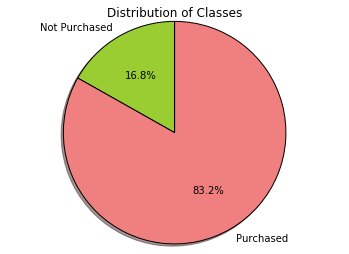

In [191]:
%matplotlib inline
labels = 'Not Purchased', 'Purchased'
positive = sum(data['lapse7'] == 1)
negative = sum(data['lapse7'] == 0)
sizes = [positive, negative]
colors = ['yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Distribution of Classes")
plt.show()

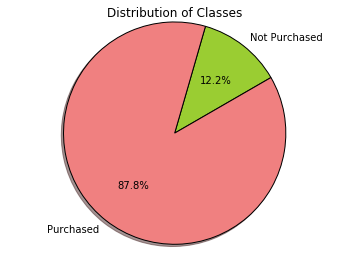

In [192]:
positive = sum(data['lapse14'] == 1)
negative = sum(data['lapse14'] == 0)
sizes = [positive, negative]
colors = ['yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=30)
plt.axis('equal')
plt.title("Distribution of Classes")
plt.show()

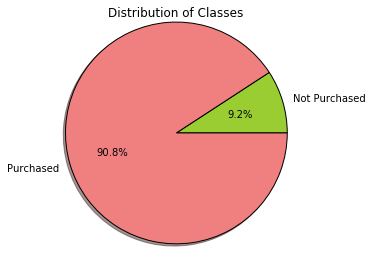

In [193]:
positive = sum(data['lapse30'] == 1)
negative = sum(data['lapse30'] == 0)
sizes = [positive, negative]
colors = ['yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.title("Distribution of Classes")
plt.show()

We see that as we increase our lapse period, the number of transactions that do not churn decreases. Features that represent unique IDs are not generalizable for classification and should be removed.

# Feature Engineering 1

In [349]:
del data['idfa']
del data['rn']

We may want to convert `event_time` to a time stamp. For example, `event_time` could be converted to a feature that represents the number of minutes from or to midnight, whichever is less. We need to throw away `hours_until` because that feature is used to determine our label (i.e. if `hours_until` > 7 then 1 else 0). However, we can keep `hours_prior` to current purchase.

### Date Time

In [350]:
print(data['event_time'][0])

2016-03-22 23:11:58


In [351]:
temp = np.squeeze(data.as_matrix(['event_time']))
func = np.vectorize(datetime.strptime)
dtVec = func(temp, "%Y-%m-%d %H:%M:%S")
print(dtVec[:10])

[datetime.datetime(2016, 3, 22, 23, 11, 58)
 datetime.datetime(2016, 3, 1, 12, 14, 37)
 datetime.datetime(2016, 3, 14, 0, 27, 2)
 datetime.datetime(2016, 3, 3, 22, 50, 33)
 datetime.datetime(2016, 3, 4, 3, 20, 3)
 datetime.datetime(2016, 3, 13, 3, 53, 47)
 datetime.datetime(2016, 3, 25, 0, 14, 42)
 datetime.datetime(2016, 3, 22, 17, 47, 33)
 datetime.datetime(2016, 3, 17, 3, 5, 58)
 datetime.datetime(2016, 3, 24, 3, 21, 20)]


Let us define a function that converts our event times to closest time from/to midnight in minutes

In [332]:
def TimeToFromMidnight(dt):
    h = dt.hour
    m = dt.minute
    mTotal = h*60 + m
    if (1440 - mTotal > mTotal):
        return mTotal
    else:
        return (1440 - mTotal)

In [352]:
TimeToFromMidnightVec = np.vectorize(TimeToFromMidnight)
times = TimeToFromMidnightVec(dtVec)
print(times[:10])

[ 49 706  27  70 200 233  14 373 185 201]


Add this new timestamp feature to our dataframe

In [353]:
data['timeMN'] = times

Delete original `event_time` data

In [354]:
del data['event_time']

Let's visualize the distribution of time stamp for churn and non-churn transactions to see if certain transactions have any time preferences

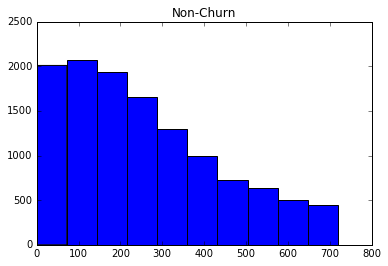

In [355]:
%matplotlib inline
posTime = np.squeeze(data.loc[(data['lapse7'] == 1), ['timeMN']]).astype('int')
negTime = np.squeeze(data.loc[(data['lapse7'] == 0), ['timeMN']]).astype('int')
plt.hist([posTime])
plt.title("Non-Churn")
plt.show()

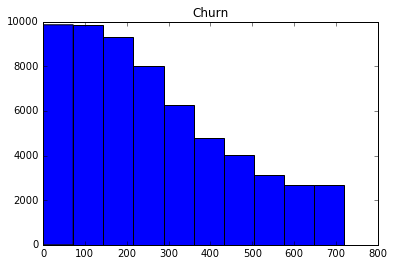

In [356]:
plt.hist([negTime])
plt.title("Churn")
plt.show()

There doesn't appear to be any preference in purchase time between churn and non-churn transactions. However, it is noteworthy that in general, there is a preference for purchasing close to midnight (~3 hours within midnight)

### Email Status

Convert email status to binary

In [357]:
data['hasemail'] = data['hasemail'].astype(int)
print(data['hasemail'][:5])

0    1
1    1
2    1
3    0
4    1
Name: hasemail, dtype: int64


The rationale for including whether user associated with transaction has provided email is because providing email awards the user with in-game credits. However, this is a one-time event and may not be useful in separating churn from non-churn transactions.

In [358]:
print("Proportion of churn transactions with email: ")
print(np.mean(data.loc[(data['lapse7'] == 1), ['hasemail']]))

Proportion of churn transactions with email: 
hasemail    0.488395
dtype: float64


In [359]:
print("Proportion of non-churn transactions with email: ")
print(np.mean(data.loc[(data['lapse7'] == 0), ['hasemail']]))

Proportion of non-churn transactions with email: 
hasemail    0.497487
dtype: float64


From this point on, some additional features will be constructed based on which lapse we choose, hence we should save the data so that we can compare lapses later. Before any comparisons between lapses are made, we choose `lapse7` as default

In [361]:
pickle.dump(data, open(dataDir + "data.p", 'wb'))

In [413]:
data = pickle.load(open(dataDir + "data.p", 'rb'))

### Hours Prior to Current Purchase
We want to see if we should keep `hours_prior`, which contains `(null)` values corresponding to no purchases prior to current purchase. Inclusion of `hours_prior` requires a strategy for treating `(null)` values. First see how many `(null)` values there are as a percentage of our data.

In [414]:
print("Percentage null: ")
np.mean(data['hours_prior'] == '(null)')

Percentage null: 


0.070324278391491468

First see if `hours_prior` is worth including:

In [415]:
pos = np.squeeze(data.loc[(data['hours_prior'] != '(null)') & (data['lapse7'] == 1), ['hours_prior']]).astype('int')
print(pos.shape)
neg = np.squeeze(data.loc[(data['hours_prior'] != '(null)') & (data['lapse7'] == 0), ['hours_prior']]).astype('int')
print(neg.shape)

(9757,)
(58074,)


In [367]:
print(pos.describe())
print(neg.describe())

count    9757.000000
mean     -195.475556
std       313.981365
min     -2178.000000
25%      -237.000000
50%       -62.000000
75%        -4.000000
max         0.000000
Name: hours_prior, dtype: float64
count    58074.000000
mean       -42.216878
std        126.783217
min      -2146.000000
25%        -27.000000
50%         -3.000000
75%          0.000000
max          0.000000
Name: hours_prior, dtype: float64


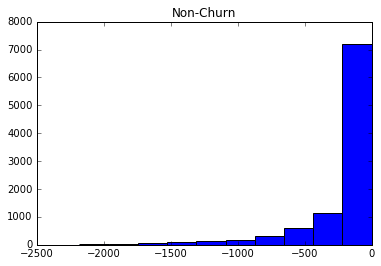

In [368]:
plt.hist([pos])
plt.title("Non-Churn")
plt.show()

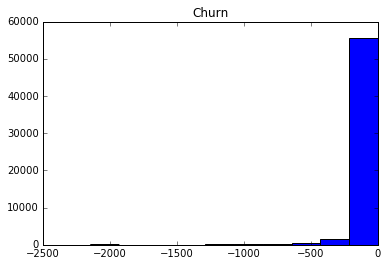

In [369]:
plt.hist([neg])
plt.title("Churn")
plt.show()

It appears that non-churn transactions have a larger proportion of transactions who have hours prior to current payment greater than 250 hours. A possible explanation is that non-churn transactions in general have longer time span between successive purchases. Thus, `hours_prior` may be useful and should be included.

To treat the `(null)` values, we are going to impute them with the mean `hours_prior` values of transactions that share the same class. 

In [416]:
posMean = int(np.mean(pos))
negMean = int(np.mean(neg))
data.loc[(data['lapse7'] == 1) & (data['hours_prior'] == '(null)'), ['hours_prior']] = posMean
data.loc[(data['lapse7'] == 0) & (data['hours_prior'] == '(null)'), ['hours_prior']] = negMean

We should delete `hours_until`

In [417]:
del data['hours_until']

# Data Visualization

First set the labels

In [418]:
y1 = data['lapse7']
y2 = data['lapse14']
y3 = data['lapse30']
del data['lapse7']
del data['lapse14']
del data['lapse30']

First set the labels

In [419]:
data.shape

(72962, 135)

Scale each feature in the data matrix so that each feature has zero mean and unit variance.

In [375]:
dataScale = pp.scale(data)

Let us whiten the data and plot a PCA of the total data

In [376]:
pca = PCA(n_components=135, whiten=True)
pca_transformed = pca.fit_transform(dataScale)

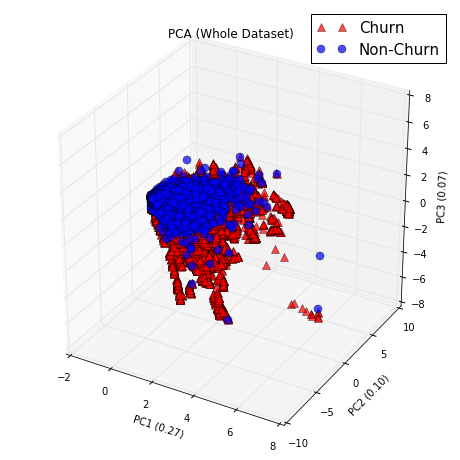

In [377]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', markersize=8, 
        alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', markersize=8, 
        color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Whole Dataset)")
ax.legend(loc='upper right')
plt.show()

Let us see how well our three components "capture" the total structure of the data.

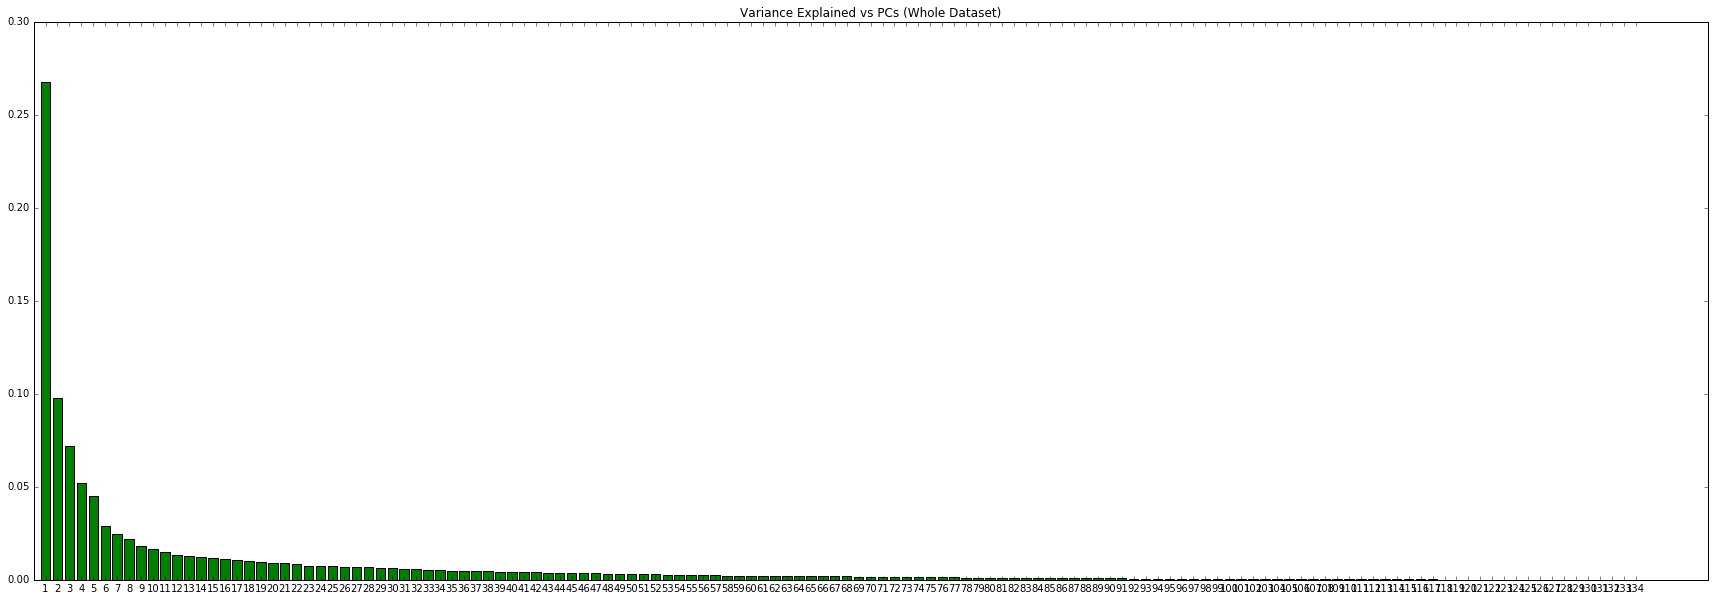

In [378]:
plt.figure(figsize=(30,10))
plt.title("Variance Explained vs PCs (Whole Dataset)")
plt.bar(list(range(1, len(pca.explained_variance_ratio_) + 1)), pca.explained_variance_ratio_,
       color="g", align="center")
plt.xticks(list(range(1, len(pca.explained_variance_ratio_))), list(range(1, len(pca.explained_variance_ratio_))))
plt.show()

It looks like our first three PCs do a reasonable job in capturing the structure of the data compared with the rest of the components. Let us perform PCA again, but this time without the time series data:

In [251]:
print(data.columns.values)

['rev' 'hasemail' 'fb_friends' 'e_viptier' 'e_purchaseamount' 'credits'
 'e_level' 'hours_prior' 'ooc_56_49d' 'ooc_49_42d' 'ooc_42_35d'
 'ooc_35_28d' 'ooc_28_21d' 'ooc_21_14d' 'ooc_14_7d' 'ooc_7_6d' 'ooc_6_5d'
 'ooc_5_4d' 'ooc_4_3d' 'ooc_3_2d' 'ooc_2_1d' 'ooc_1_0d' 'ss_56_49d'
 'ss_49_42d' 'ss_42_35d' 'ss_35_28d' 'ss_28_21d' 'ss_21_14d' 'ss_14_7d'
 'ss_7_6d' 'ss_6_5d' 'ss_5_4d' 'ss_4_3d' 'ss_3_2d' 'ss_2_1d' 'ss_1_0d'
 'hb_56_49d' 'hb_49_42d' 'hb_42_35d' 'hb_35_28d' 'hb_28_21d' 'hb_21_14d'
 'hb_14_7d' 'hb_7_6d' 'hb_6_5d' 'hb_5_4d' 'hb_4_3d' 'hb_3_2d' 'hb_2_1d'
 'hb_1_0d' 'qw_56_49d' 'qw_49_42d' 'qw_42_35d' 'qw_35_28d' 'qw_28_21d'
 'qw_21_14d' 'qw_14_7d' 'qw_7_6d' 'qw_6_5d' 'qw_5_4d' 'qw_4_3d' 'qw_3_2d'
 'qw_2_1d' 'qw_1_0d' 'sp_56_49d' 'sp_49_42d' 'sp_42_35d' 'sp_35_28d'
 'sp_28_21d' 'sp_21_14d' 'sp_14_7d' 'sp_7_6d' 'sp_6_5d' 'sp_5_4d' 'sp_4_3d'
 'sp_3_2d' 'sp_2_1d' 'sp_1_0d' 'lu_56_49d' 'lu_49_42d' 'lu_42_35d'
 'lu_35_28d' 'lu_28_21d' 'lu_21_14d' 'lu_14_7d' 'lu_7_6d' 'lu_6_5d'
 'lu_5_4d

In [380]:
dataSubset = data.ix[:, list(range(8)) + [134]]
pca = PCA(n_components=9, whiten=True)
pca_transformed = pca.fit_transform(dataSubset)

Plot:

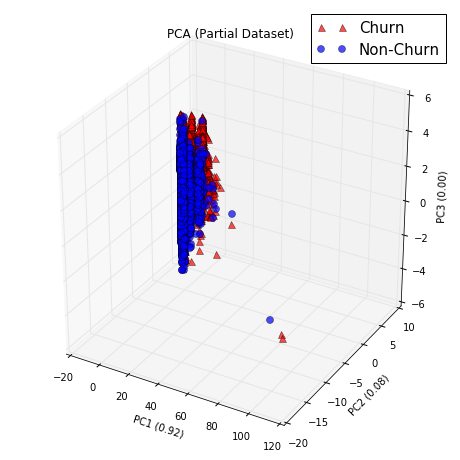

In [381]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', 
        markersize=7, alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', 
        markersize=7, color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Partial Dataset)")
ax.legend(loc='upper right')
plt.show()

Keeping the time series data makes the data look more separable. Let's look at the data two components at a time.

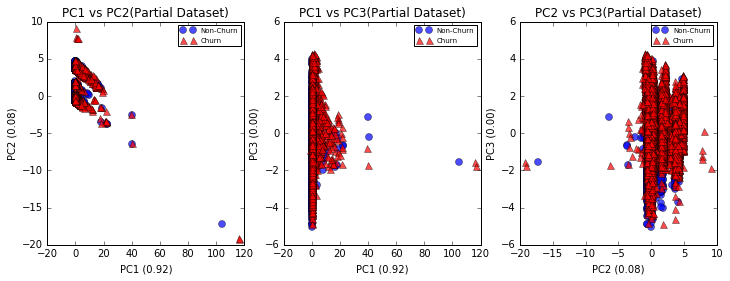

In [382]:
fig = plt.figure(figsize=(12,4))
PCs = [(0, 1), (0, 2), (1, 2)]
i = 1
for pc in PCs:
    ax = fig.add_subplot(130 + i)
    ax.plot(pca_transformed[posIdx, pc[0]], pca_transformed[posIdx, pc[1]], 'o', markersize=7, color='blue', 
            alpha=0.7, label='Non-Churn')
    ax.plot(pca_transformed[negIdx,pc[0]], pca_transformed[negIdx, pc[1]], '^', markersize=7, alpha=0.7, 
            color='red', label='Churn')
    ax.set_xlabel('PC' + str(pc[0] + 1) + ' (%.2f)' % (pca.explained_variance_ratio_[pc[0]]))
    ax.set_ylabel('PC' + str(pc[1] + 1) + ' (%.2f)'% (pca.explained_variance_ratio_[pc[1]]))
    plt.rcParams['legend.fontsize'] = 7
    plt.title("PC" + str(pc[0] + 1) + " vs " + "PC" + str(pc[1] + 1) +  "(Partial Dataset)")
    ax.legend(loc='upper right')
    i += 1
plt.show()

It looks like the time series data collected will be useful in distinguishing those who churn and those who don't. The type of time series data we have are:

1. Number of out of credit dialogs per unit time
2. Number of session starts per unit time
3. Number of heartbeats per unit time
4. Number of quality wins per unit time
5. Number of spins per unit time
6. Number of levelups per unit time
7. Number of purchases per unit time
8. Sum of revenue in period
9. Number of hourly bonus collections

Let us plot each individual feature against time to see if there are any differences between churn and no churn.

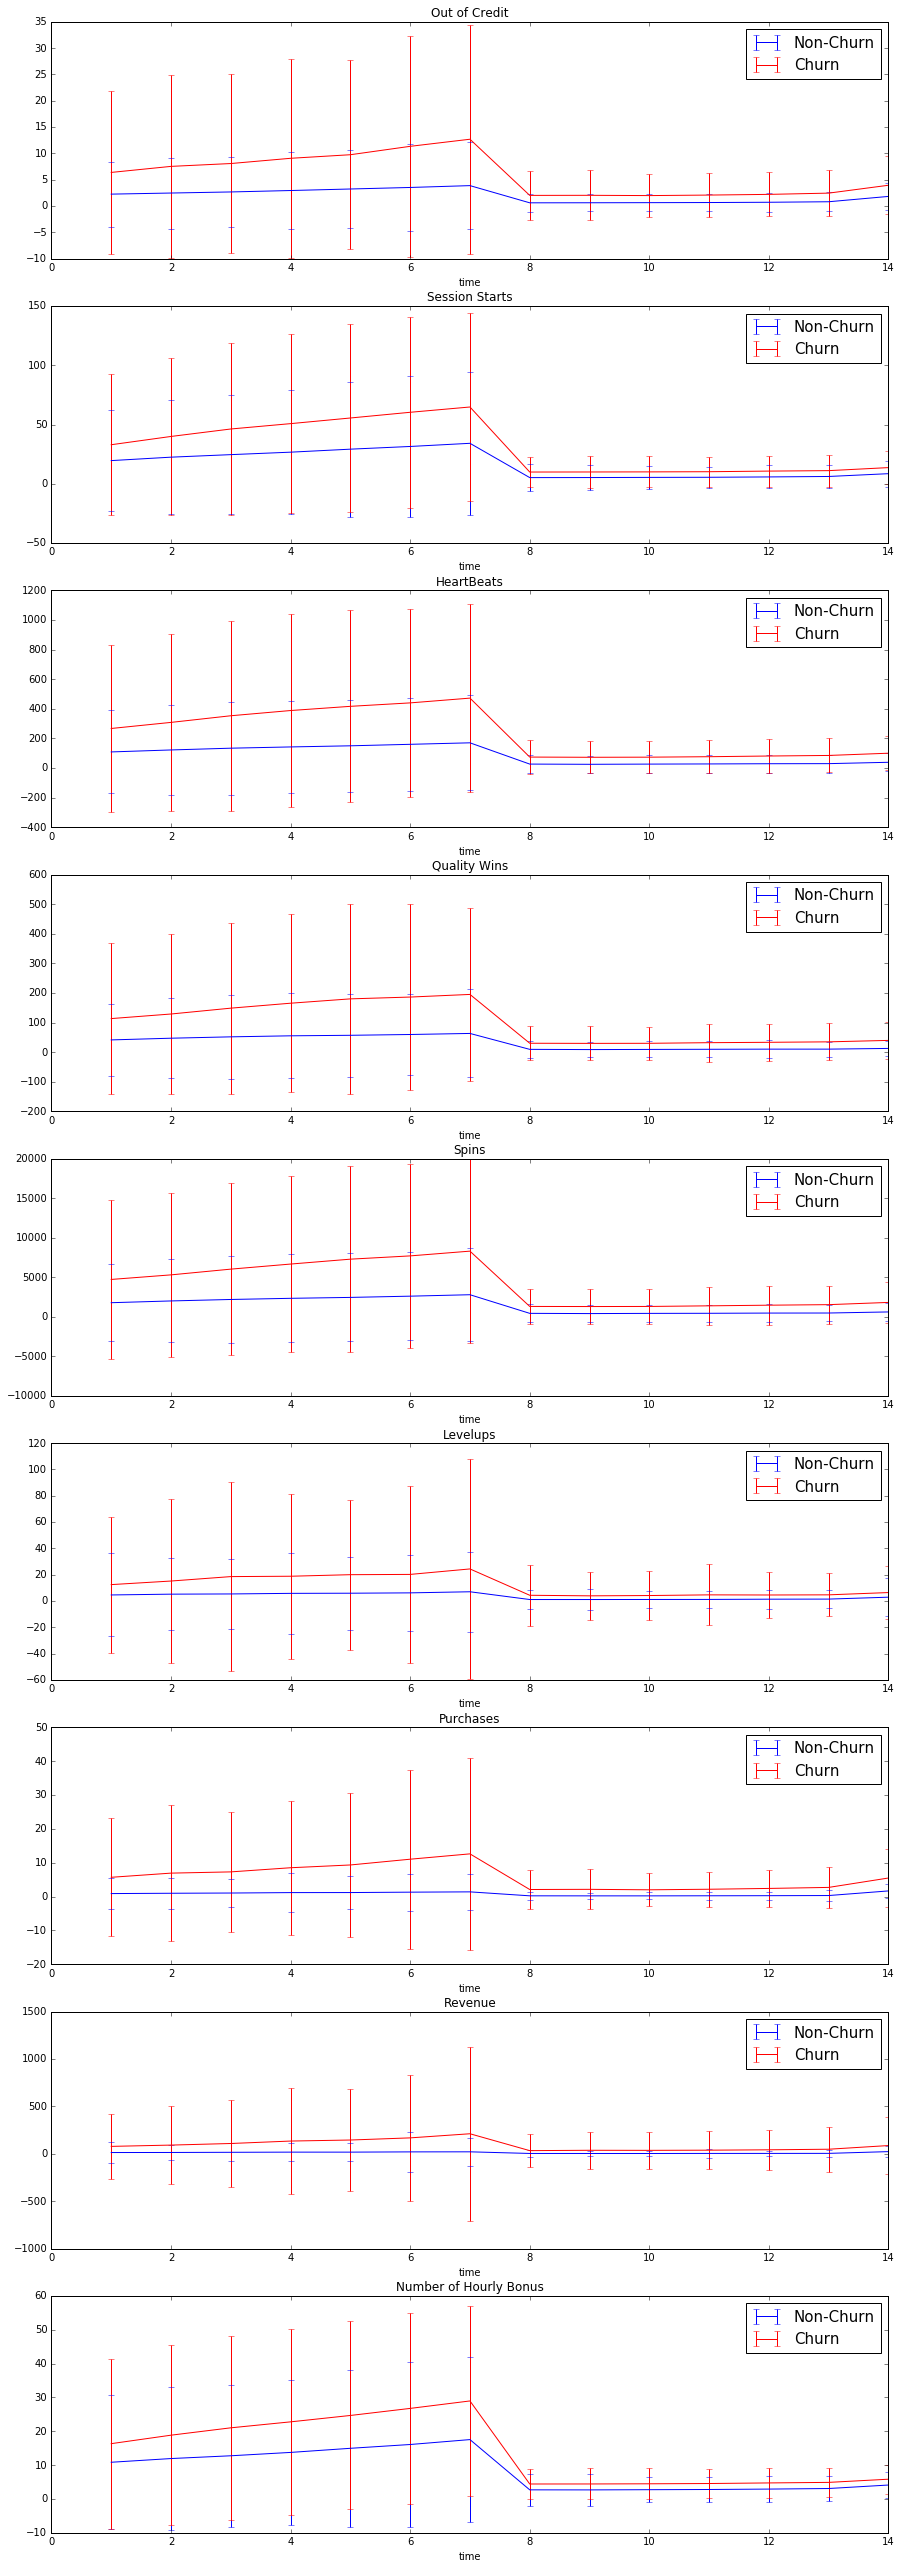

In [420]:
dataSubset = data.ix[:, 8:134]
fig = plt.figure(figsize = (15, 45))
titles = ["Out of Credit", "Session Starts", "HeartBeats", "Quality Wins", "Spins", "Levelups", "Purchases", 
         "Revenue", "Number of Hourly Bonus"]
counter = 0
for i in range(0, 126, 14):
    ax = fig.add_subplot(910 + counter + 1)
    pos = dataSubset.ix[posIdx, i:i+14]
    neg = dataSubset.ix[negIdx, i:i+14]
    posMean = pos.apply(np.mean)
    negMean = neg.apply(np.mean)
    posStd = pos.apply(np.std)
    negStd = neg.apply(np.std)
    ax.errorbar(list(range(1, 15)), posMean, yerr=posStd, color='blue', label="Non-Churn")
    ax.errorbar(list(range(1, 15)), negMean, yerr=negStd, color='red', label="Churn")
    ax.set_xlabel("time")
    ax.set_title(titles[counter])
    ax.legend(loc='upper right')
    plt.rcParams['legend.fontsize'] = 15
    counter += 1

A couple of observations can be made from these plots:

1. In general, churn players have higher mean feature values than non-churn players, although the significance is not known.
2. In general, churn players have larger standard deviations than non-churn players.

These observations suggest that churn transactions in general are more diverse than non-churn playes. 

# Feature Engineering 2
### Number of Times Exceeding 1-2 SD
We will create our new features as the number of times a feature value exceeds or goes below 1-2 standard deviations from the mean value over time.

In [384]:
newFeatures = {}
features = ["oocNew", "ssNew", "hbNew", "qwNew", "spinsNew", "luNew", "purchaseNew", 
         "revNew", "bonusNew"]
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
counter = 0

for i in range(0, 126, 14):
    sub = dataSubset.ix[:, i:i+14].as_matrix()
    means = np.mean(sub, axis=1).reshape(sub.shape[0], 1)
    stds = np.std(sub, axis=1).reshape(sub.shape[0], 1)
    truth = (sub > means + 1*stds) | (sub < means - 1*stds)
    newFeatures[counter] = np.sum(truth, axis=1)
    counter += 1

newFeatures = pd.DataFrame(newFeatures)
newFeatures.columns = features
newFeatures.head()

,oocNew,ssNew,hbNew,qwNew,spinsNew,luNew,purchaseNew,revNew,bonusNew
0,3,4,4,1,1,1,2,2,4
1,1,2,1,1,1,1,1,2,1
2,1,1,2,2,2,2,1,1,2
3,1,8,4,5,5,7,7,7,5
4,2,1,2,1,2,2,1,1,1


Let us see how well our newly created features separate out churn players from non-churn players.

In [385]:
newFeatures = newFeatures.as_matrix()

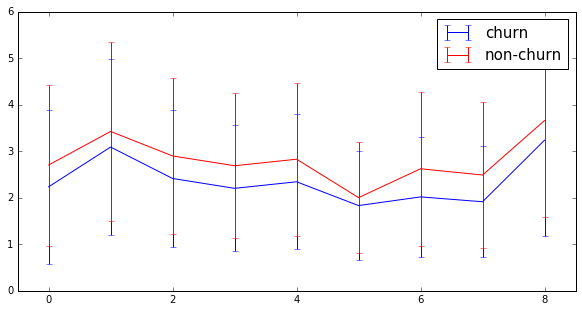

In [386]:
pos = newFeatures[posIdx, :]
neg = newFeatures[negIdx, :]
posMeans = np.mean(pos, axis=0)
posStds = np.std(pos, axis=0)
negMeans = np.mean(neg, axis=0)
negStds = np.std(neg, axis=0)
plt.figure(figsize = (10, 5))
plt.errorbar(list(range(len(features))), posMeans, yerr=posStds, color="blue", label="churn")
plt.errorbar(list(range(len(features))), negMeans, yerr=negStds, color="red", label="non-churn")
plt.xlim([-0.5, 8.5])
plt.legend(loc="upper right")
plt.show()

Unfortunately this new feature doesn't seem to capture the differences well.

### Range
Given that churn transactions are more volatile, let us construct a new feature using range (measure of dispersion) over time for each of the 9 time-series features as new features.

In [421]:
newFeatures = {}
features = ["oocRange", "ssRange", "hbRange", "qwRange", "spinsRange", "luRange", "purchaseRange", 
         "revRange", "bonusRange"]
counter = 0

for i in range(0, 126, 14):
    sub = dataSubset.ix[:, i:i+14].as_matrix()
    maxVal = np.max(sub, axis=1)
    minVal = np.min(sub, axis=1)
    r = maxVal - minVal
    newFeatures[counter] = r
    counter += 1

newFeatures = pd.DataFrame(newFeatures)
newFeatures.columns = features
newFeatures.head()

,oocRange,ssRange,hbRange,qwRange,spinsRange,luRange,purchaseRange,revRange,bonusRange
0,44,258,563,625,21604,78,17,259.83,83
1,6,32,254,187,5392,5,34,66.66,19
2,28,175,1116,441,23790,27,14,554.86,79
3,4,60,1268,278,14508,4,2,29.98,47
4,3,4,98,48,1769,33,18,149.82,3


Let's visualize how well this new feature does at separating classes using histograms

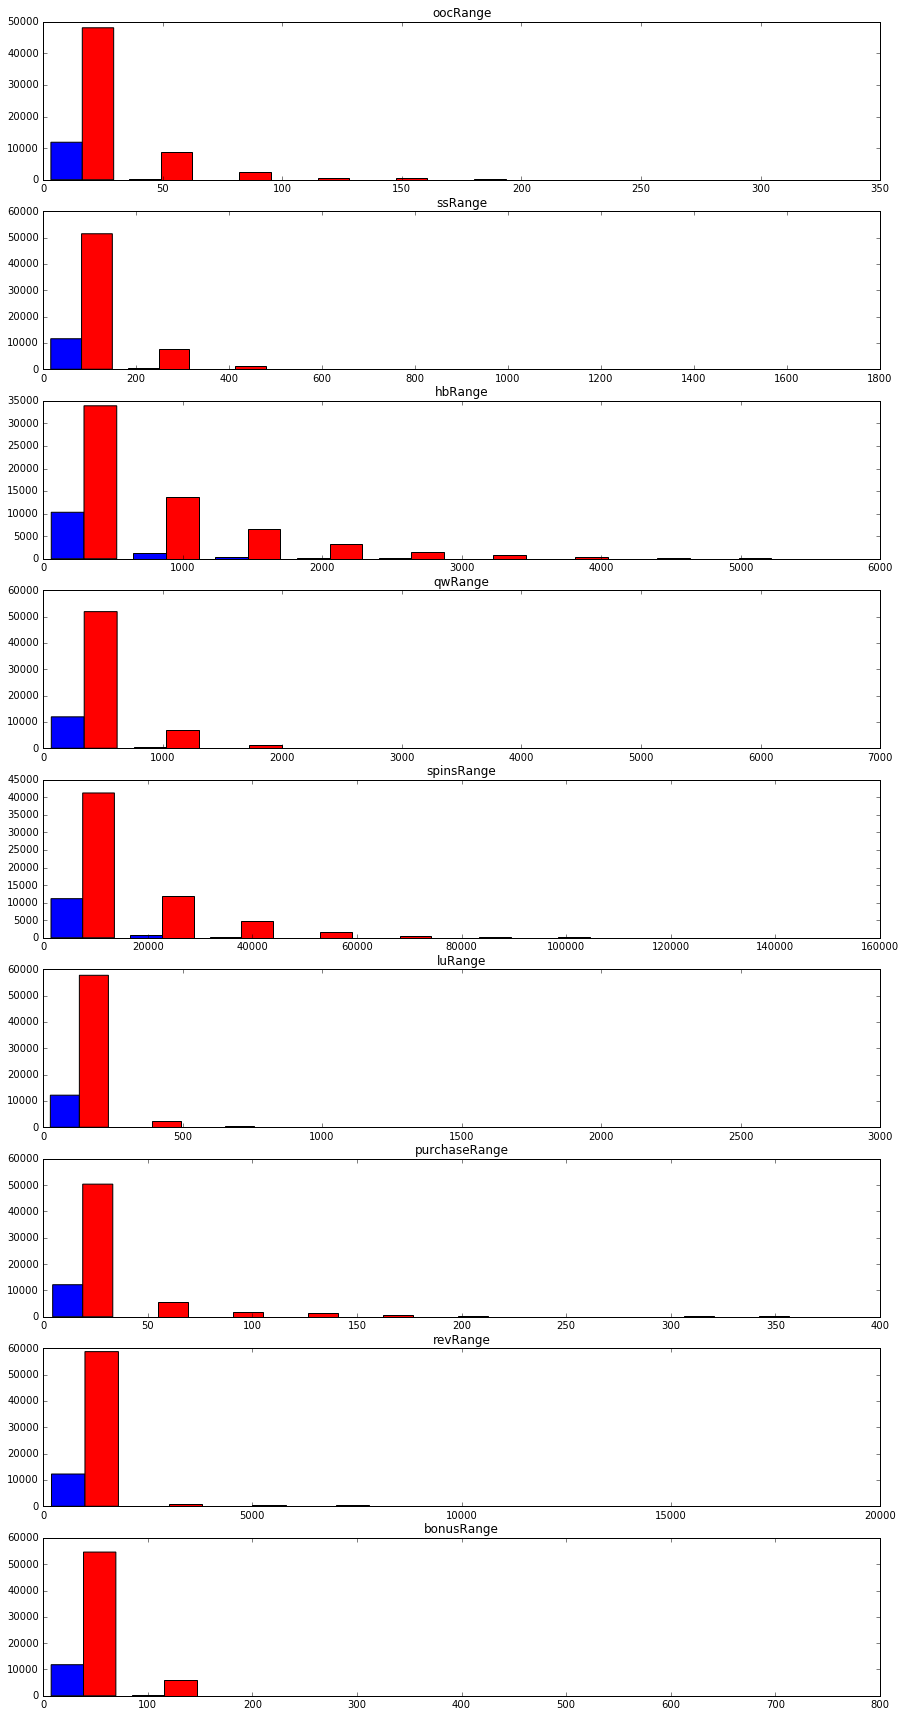

In [388]:
fig = plt.figure(figsize = (15, 30))
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
pos = newFeatures.iloc[posIdx, :]
neg = newFeatures.iloc[negIdx, :]
counter = 1
n = 20
for feature in features:
    ax = fig.add_subplot(910 + counter)
    posF = pos[feature]
    negF = neg[feature]
    ax.hist([posF, negF], color=['blue', 'red'], label=['Non-churn', 'Churn'])
    ax.set_title(feature)
    counter += 1

It looks like this feature may capture the class differences, as non-churn trasactions generally have lower maximum values for each of the 9 features.

In [422]:
newData = pd.concat([data, newFeatures], axis=1)
newData['lapse7'] = y1
print(data.shape)
print(newData.shape)

(72962, 135)
(72962, 145)


In [423]:
pickle.dump(newData, open(dataDir + "newData7.p", 'wb'))

# Which Lapse is Better?

Rocket Games is interested in high recall of non-churn transactions, so the optimization objective is to maximize the area under the precision-recall curve. However, this depends on how we define non-churn transactions. We have the options of 7 days, 14 days, or even 30 days. Which definition is chosen will depend on the tradeoff between AUCs and how frequent Rocket Games would like the purchases to be. Let us first contruct the `hours_prior` and `range` features for `lapse14` and `lapse30` respectively, and compare all the AUCs to see which lapse will allow both maximal recall and precision.

In [396]:
data = pickle.load(open(dataDir + "data.p", 'rb'))
data.head()

,rev,hasemail,fb_friends,e_viptier,e_purchaseamount,credits,e_level,hours_until,hours_prior,lapse7,...,chb_21_14d,chb_14_7d,chb_7_6d,chb_6_5d,chb_5_4d,chb_4_3d,chb_3_2d,chb_2_1d,chb_1_0d,timeMN
0,14.99,1,0,4,90000,2529.000000,332,0,0,0,...,70,83,7,7,8,7,2,7,6,49
1,4.99,1,0,3,10000,30.000000,84,(null),0,1,...,0,0,0,0,0,0,0,0,1,706
2,49.99,1,0,4,330000,99.884802,319,13,-1,0,...,56,94,16,17,19,17,20,16,20,27
3,14.99,0,0,3,90000,3287.000000,150,120,-51,0,...,51,48,7,6,8,5,6,6,4,70
4,4.99,1,0,0,10000,66.000000,58,0,-1,0,...,0,0,0,0,0,0,0,0,1,200


### Range Again

Since computing the ranges for each feature does not depend on the lapse chosen, compute the range once and add it later to the data matrices corresponding to `lapse14` and `lapse30` respectively.

In [400]:
print(dataTemp.shape)

(72962, 138)


In [403]:
dataSubset = data.ix[:, 11:137]
newFeatures = {}
features = ["oocRange", "ssRange", "hbRange", "qwRange", "spinsRange", "luRange", "purchaseRange", 
         "revRange", "bonusRange"]
counter = 0

for i in range(0, 126, 14):
    sub = dataSubset.ix[:, i:i+14].as_matrix()
    maxVal = np.max(sub, axis=1)
    minVal = np.min(sub, axis=1)
    r = maxVal - minVal
    newFeatures[counter] = r
    counter += 1

newFeatures = pd.DataFrame(newFeatures)
newFeatures.columns = features
newFeatures.head()

,oocRange,ssRange,hbRange,qwRange,spinsRange,luRange,purchaseRange,revRange,bonusRange
0,44,258,563,625,21604,8177,22,224.85,259.83
1,6,32,254,187,5392,427,34,66.66,19.00
2,28,191,1116,640,23790,9787,14,554.86,104.96
3,4,66,1304,278,14657,1061,2,29.98,46.00
4,3,4,98,48,1769,799,29,149.82,14.97


### Lapse14

Impute the `hours_prior` feature

In [397]:
dataTemp = copy.deepcopy(data)
pos = np.squeeze(dataTemp.loc[(dataTemp['hours_prior'] != '(null)') & (dataTemp['lapse14'] == 1), 
                          ['hours_prior']]).astype('int')
print(pos.shape)
neg = np.squeeze(dataTemp.loc[(dataTemp['hours_prior'] != '(null)') & (dataTemp['lapse14'] == 0), 
                              ['hours_prior']]).astype('int')
print(neg.shape)

(6681,)
(61150,)


In [398]:
posMean = int(np.mean(pos))
negMean = int(np.mean(neg))
dataTemp.loc[(dataTemp['lapse14'] == 1) & (dataTemp['hours_prior'] == '(null)'), ['hours_prior']] = posMean
dataTemp.loc[(dataTemp['lapse14'] == 0) & (dataTemp['hours_prior'] == '(null)'), ['hours_prior']] = negMean

In [399]:
del dataTemp['hours_until']

Add the `range` feature

In [404]:
newData = pd.concat([dataTemp, newFeatures], axis=1)
del newData['lapse7']
del newData['lapse30']
pickle.dump(newData, open(dataDir + "newData14.p", 'wb'))

### Lapse 30
Impute the `hours_prior` feature

In [405]:
dataTemp = copy.deepcopy(data)
pos = np.squeeze(dataTemp.loc[(dataTemp['hours_prior'] != '(null)') & (dataTemp['lapse30'] == 1), 
                          ['hours_prior']]).astype('int')
print(pos.shape)
neg = np.squeeze(dataTemp.loc[(dataTemp['hours_prior'] != '(null)') & (dataTemp['lapse30'] == 0), 
                              ['hours_prior']]).astype('int')
print(neg.shape)

(4764,)
(63067,)


In [406]:
posMean = int(np.mean(pos))
negMean = int(np.mean(neg))
dataTemp.loc[(dataTemp['lapse30'] == 1) & (dataTemp['hours_prior'] == '(null)'), ['hours_prior']] = posMean
dataTemp.loc[(dataTemp['lapse30'] == 0) & (dataTemp['hours_prior'] == '(null)'), ['hours_prior']] = negMean

In [407]:
del dataTemp['hours_until']

Add the `range` feature

In [408]:
newData = pd.concat([dataTemp, newFeatures], axis=1)
del newData['lapse7']
del newData['lapse14']
pickle.dump(newData, open(dataDir + "newData30.p", 'wb'))

### Comparison

In [559]:
newData7 = pickle.load(open(dataDir + "newData7.p", 'rb'))
y7 = newData7['lapse7']
del newData7['lapse7']
newData14 = pickle.load(open(dataDir + "newData14.p", 'rb'))
y14 = newData14['lapse14']
del newData14['lapse14']
newData30 = pickle.load(open(dataDir + "newData30.p", 'rb'))
y30 = newData30['lapse30']
del newData30['lapse30']

We will use a decision tree to roughly determine the differences between the lapses. 

#### Lapse 7

We use the 80-20 split rule for train and test sets

In [560]:
Xtrain, Xtest, ytrain, ytest = train_test_split(newData7, y7, test_size=0.20)

In [564]:
dt = DecisionTreeClassifier(class_weight="balanced")
depths = {'max_depth':list(range(4, 26, 2))}
clf = grid_search.GridSearchCV(dt, depths, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

In [565]:
clf.grid_scores_

[mean: 0.63075, std: 0.00333, params: {'max_depth': 4},
 mean: 0.57818, std: 0.05420, params: {'max_depth': 6},
 mean: 0.63435, std: 0.00300, params: {'max_depth': 8},
 mean: 0.60459, std: 0.00364, params: {'max_depth': 10},
 mean: 0.56673, std: 0.00525, params: {'max_depth': 12},
 mean: 0.52707, std: 0.00317, params: {'max_depth': 14},
 mean: 0.50951, std: 0.00667, params: {'max_depth': 16},
 mean: 0.49741, std: 0.00800, params: {'max_depth': 18},
 mean: 0.49144, std: 0.00584, params: {'max_depth': 20},
 mean: 0.48673, std: 0.01040, params: {'max_depth': 22},
 mean: 0.48866, std: 0.00857, params: {'max_depth': 24}]

In [571]:
clf = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
clf.fit(Xtrain, ytrain)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.78585623244


Now evaluate area under precision-recall (PR) curve

In [572]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.635006489704


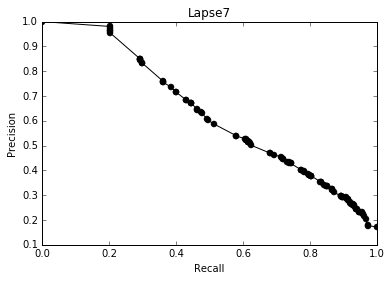

In [573]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

#### Lapse14

In [583]:
Xtrain, Xtest, ytrain, ytest = train_test_split(newData14, y14, test_size=0.20)

In [575]:
dt = DecisionTreeClassifier(class_weight="balanced")
depths = {'max_depth':list(range(4, 26, 2))}
clf = grid_search.GridSearchCV(dt, depths, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

In [576]:
clf.grid_scores_

[mean: 0.61786, std: 0.01487, params: {'max_depth': 4},
 mean: 0.61474, std: 0.05834, params: {'max_depth': 6},
 mean: 0.64578, std: 0.01373, params: {'max_depth': 8},
 mean: 0.61848, std: 0.01715, params: {'max_depth': 10},
 mean: 0.58528, std: 0.02124, params: {'max_depth': 12},
 mean: 0.56185, std: 0.01463, params: {'max_depth': 14},
 mean: 0.54032, std: 0.01117, params: {'max_depth': 16},
 mean: 0.52815, std: 0.01323, params: {'max_depth': 18},
 mean: 0.52173, std: 0.01029, params: {'max_depth': 20},
 mean: 0.52163, std: 0.01242, params: {'max_depth': 22},
 mean: 0.51463, std: 0.01131, params: {'max_depth': 24}]

In [584]:
clf = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
clf.fit(Xtrain, ytrain)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.776673747687


Now evaluate area under precision-recall (PR) curve

In [580]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.625845337173


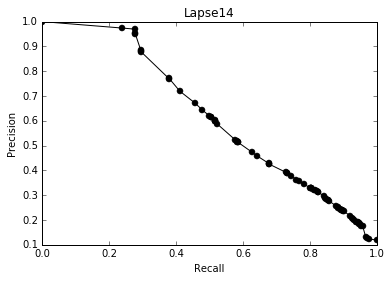

In [582]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse14")
plt.show()

#### Lapse30

In [585]:
Xtrain, Xtest, ytrain, ytest = train_test_split(newData30, y30, test_size=0.20)

In [586]:
dt = DecisionTreeClassifier(class_weight="balanced")
depths = {'max_depth':list(range(4, 26, 2))}
clf = grid_search.GridSearchCV(dt, depths, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

In [587]:
clf.grid_scores_

[mean: 0.60237, std: 0.01255, params: {'max_depth': 4},
 mean: 0.64485, std: 0.00641, params: {'max_depth': 6},
 mean: 0.63991, std: 0.00462, params: {'max_depth': 8},
 mean: 0.61361, std: 0.00457, params: {'max_depth': 10},
 mean: 0.58283, std: 0.00446, params: {'max_depth': 12},
 mean: 0.55597, std: 0.00904, params: {'max_depth': 14},
 mean: 0.54690, std: 0.00908, params: {'max_depth': 16},
 mean: 0.54745, std: 0.00756, params: {'max_depth': 18},
 mean: 0.53645, std: 0.00474, params: {'max_depth': 20},
 mean: 0.53010, std: 0.00766, params: {'max_depth': 22},
 mean: 0.52622, std: 0.00806, params: {'max_depth': 24}]

In [588]:
clf = DecisionTreeClassifier(max_depth=6, class_weight="balanced")
clf.fit(Xtrain, ytrain)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.815253888851


Now evaluate area under precision-recall (PR) curve

In [589]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.658375900669


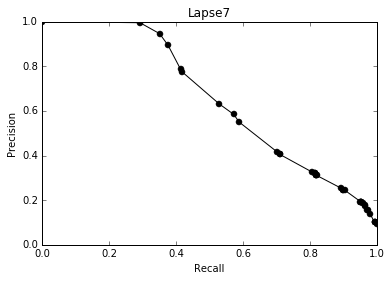

In [590]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

It appears that there is no significant difference in area under the PR curve across different lapses. We shall proceed to choose lapse7 because intervention at this level may result in more frequent payments.

# Feature Selection

Let's train a decision tree, and see how well a decision tree performs on our testset

In [15]:
newData7 = pickle.load(open(dataDir + "newData7.p", 'rb'))
y7 = newData7['lapse7']
del newData7['lapse7']

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(newData7, y7, test_size=0.2)
clf = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
clf.fit(Xtrain, ytrain)
pred = clf.predict(Xtest)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.756938258069


In [601]:
pred = clf.predict(Xtest)
print(recall_score(ytest, pred))

0.79525950143


Confusion Matrix

In [20]:
confusion_matrix(ytest, pred)
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,9025,3069,12094
1,478,2021,2499
All,9503,5090,14593


In [16]:
tree.export_graphviz(clf, out_file='output/tree.dot') 

Let us save our modified dataset

In [602]:
pickle.dump(Xtrain, open(dataDir + "Xtrain.p", 'wb'))
pickle.dump(ytrain, open(dataDir + "ytrain.p", 'wb'))
pickle.dump(Xtest, open(dataDir + "Xtest.p", 'wb'))
pickle.dump(ytest, open(dataDir + "ytest.p", 'wb'))

Load our modified dataset

In [3]:
Xtrain = pickle.load(open(dataDir + "Xtrain.p", "rb"))
ytrain = pickle.load(open(dataDir + "ytrain.p", "rb"))
Xtest = pickle.load(open(dataDir + "Xtest.p", "rb"))
ytest = pickle.load(open(dataDir + "ytest.p", "rb"))

Import Calvin's decision tree, which will output all the top features used to separate the classes.

In [4]:
from DecisionTree import DecisionTree

In [5]:
clf2 = DecisionTree(stop=0.35, output=True, minSize=1000)
clf2.train(Xtrain, ytrain)

Let's see how well Calvin's decision tree performs on the test set.

In [6]:
pred = clf2.predict(Xtest)
print("Test set accuracy:")
print(np.mean(pred == ytest))

Test set accuracy:
0.871376687453


In [8]:
attributes = clf2.attributes
print(attributes)

['hours_prior', 'purchaseRange', 'lu_1_0d', 'qw_2_1d', 'pv_14_7d', 'e_viptier', 'spinsRange', 'rev_14_7d', 'rev_21_14d', 'rev_28_21d', 'rev_5_4d', 'pv_1_0d', 'sp_5_4d', 'revRange', 'rev', 'pv_3_2d', 'qw_6_5d', 'sp_42_35d', 'ooc_56_49d', 'hb_14_7d', 'qw_1_0d', 'hb_7_6d', 'rev_3_2d', 'pv_21_14d', 'credits', 'qw_35_28d', 'hb_4_3d', 'pv_5_4d', 'rev_4_3d', 'pv_4_3d', 'rev_2_1d', 'pv_2_1d', 'sp_4_3d', 'luRange', 'ooc_14_7d', 'sp_2_1d', 'ss_56_49d', 'rev_1_0d', 'e_level', 'chb_56_49d', 'hb_56_49d', 'oocRange', 'ooc_2_1d']


In [9]:
pickle.dump(attributes, open(outputDir + "attributes.p", 'wb'))

In [299]:
attributes = pickle.load(open(outputDir + "attributes.p", 'rb'))

It looks like the best features are the time-series data, of which number of purchases seem to be the best. The best none time-series data are `credit` and `e_viptier`. 

In [10]:
colNames = Xtrain.columns.values
idx = np.where(np.in1d(colNames, attributes))[0]
print(len(idx))
dataSubset = Xtrain.iloc[:, idx]
print(dataSubset.shape)

43
(58369, 43)


Let us see how separable the two classes are with these selected 24 features.

In [11]:
pca = PCA(n_components=43, whiten=True)
pca_transformed = pca.fit_transform(dataSubset)
print(pca_transformed.shape)

(58369, 43)


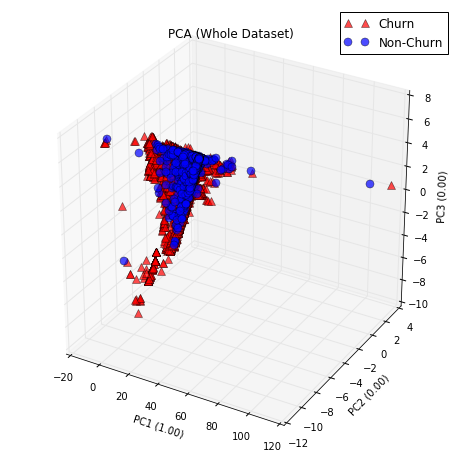

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(ytrain == 1)[0]
negIdx = np.where(ytrain == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', markersize=8, 
        alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', markersize=8, 
        color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Whole Dataset)")
ax.legend(loc='upper right')
plt.show()

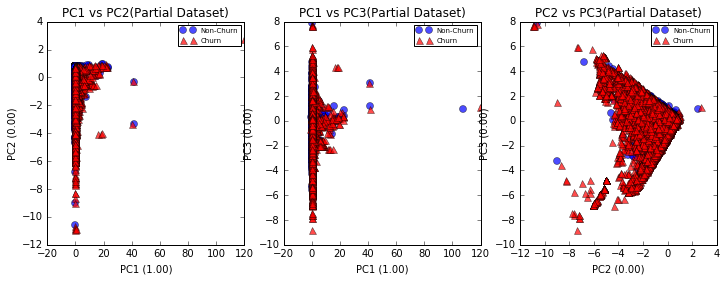

In [13]:
fig = plt.figure(figsize=(12,4))
PCs = [(0, 1), (0, 2), (1, 2)]
i = 1
for pc in PCs:
    ax = fig.add_subplot(130 + i)
    ax.plot(pca_transformed[posIdx, pc[0]], pca_transformed[posIdx, pc[1]], 'o', markersize=7, color='blue', 
            alpha=0.7, label='Non-Churn')
    ax.plot(pca_transformed[negIdx,pc[0]], pca_transformed[negIdx, pc[1]], '^', markersize=7, alpha=0.7, 
            color='red', label='Churn')
    ax.set_xlabel('PC' + str(pc[0] + 1) + ' (%.2f)' % (pca.explained_variance_ratio_[pc[0]]))
    ax.set_ylabel('PC' + str(pc[1] + 1) + ' (%.2f)'% (pca.explained_variance_ratio_[pc[1]]))
    plt.rcParams['legend.fontsize'] = 7
    plt.title("PC" + str(pc[0] + 1) + " vs " + "PC" + str(pc[1] + 1) +  "(Partial Dataset)")
    ax.legend(loc='upper right')
    i += 1
plt.show()